# 📌 Mid-Term Project Submission: Multi-agent AI Travel Agent
## 🔍 Overview  
This notebook builds a preliminary prototype of a multi-agent AI travel system including the following key steps.
1.  Data sourcing
2.  RAG pipeline
3.  Multi-agent system
4.  Chunking, embedding, and fine-tuning
5.  Comparative results of base agent and alternate agent using fine-tuned embedding model


# 📌 Table of Contents
- [1. Data sourcing](#1-data-sourcing)
- [RAG Pipeline](#RAG Pipeline)  
- [3. Multi-agent system](#3-multi-agent-system)
- [Results](#results)

## RAG Pipeline
(content...)

## Results
(content...)

### WALL OF IMPORTS

## 1. Data Sourcing

In [ ]:
%run "wall_of_imports.ipynb"

In [ ]:
%run "itinerary_agent.ipynb"
%run "flight_agent.ipynb"
# %run "accommodation_agent.ipynb"

In [2]:
# os.environ["OPENAI_API_KEY"] = "XX"
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
# Set the LLM Configuration
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [3]:
%run "agent_state.ipynb"

In [4]:
%run "amadeus_data_pipeline.ipynb"

In [6]:
%%time
# Build the knowledge base
travel_db = build_travel_knowledge_base()
print(f"Knowledge base built with {len(travel_db.index_to_docstore_id)} documents")

Knowledge base built with 2553 documents
CPU times: total: 2 s
Wall time: 38.9 s


In [7]:
len(travel_db.index_to_docstore_id)

2553

In [8]:
# QUALITY CHECK OUTPUT: Print contents of travel_db (a langchain_community.vectorstores.faiss.faiss object)
# Print each row in the vector store object
for index, doc_id in travel_db.index_to_docstore_id.items():
    doc = travel_db.docstore.search(doc_id) # Get the document from docstore using doc_id
    print(f"Index: {index}")
    print(f"Document ID: {doc_id}")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}\n")

Index: 0
Document ID: b7dbd450-02fd-4aa7-b7f8-1156a192d979
Content: Destination: Paris, France
        
        Description: Known as the City of Light, Paris is famous for the Eiffel Tower, Louvre Museum, and exquisite cuisine. Best time to visit is April-June or September-October for mild weather and fewer crowds.
        
        Top Attractions: Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, Montmartre, Champs-Élysées
        
        Local Cuisine: Croissants, Escargot, Coq au Vin, Macarons, French Wine
        
        Transportation: Excellent public transportation with Metro, buses and RER trains. The Paris Visite travel pass offers unlimited travel on all transport networks.
        
        Weather: Temperate climate with mild winters and warm summers. Spring (March-May) and Fall (September-November) are particularly pleasant.
Metadata: {'type': 'destination_info', 'city': 'Paris', 'country': 'France'}

Index: 1
Document ID: 9c3aa9eb-15da-40c8-b2fd-0513032a4e83
Content: D

In [29]:
### 2. Router Agent - Determines which specialized agent to use

# Main Components of Router Agent:
# Input: Takes an AgentState object as input containing the query and other state information
# Router Prompt: Uses a ChatPromptTemplate to create a routing prompt
# Routes queries to one of four specialized agents:
# itinerary_agent
# flight_agent
# accommodation_agent
# information_agent
def router_agent(state: AgentState) -> dict:
    """Router agent that determines which specialized agent should handle the query."""

    # Step 1: Creates a chat prompt template with system and human messages
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a travel assistant router. Your job is to determine which specialized agent
        should handle the user's travel-related query. Choose the most appropriate agent from:
        
        - itinerary_agent: For requests to create travel itineraries, vacation plans, or multi-day travel schedules
        - flight_agent: For questions about flights, airfares, airlines, or flight bookings
        - accommodation_agent: For questions about hotels, resorts, accommodations, or places to stay
        - information_agent: For general travel information, destination facts, or travel advice
        
        Respond ONLY with the name of the appropriate agent. Do not include any explanations or additional text.
        """),
        ("human", "{query}")
    ])
    
    # Step 2: Uses a chain to pass the user query to the LLM, get the recommended agent name and parse the output as a string
    chain = router_prompt | llm | StrOutputParser()

    agent_executor = chain.invoke({"query": state.query}).strip()
    
    valid_agents = ["itinerary_agent", "flight_agent", "accommodation_agent", "information_agent"]

    # Step 3: Validates the response: Checks if returned agent name is in valid_agents list, else defaults to "information_agent" if invalid
    if agent_executor not in valid_agents:
        # Default to information agent if invalid response
        agent_executor = "information_agent"
            
    # Step 4: Returns state as a dictionary
    return {"agent_executor": agent_executor, 
            "query": state.query,
            "chat_history": state.chat_history,
            "agent_response": state.agent_response,
            "final_response": state.final_response,
            "context": state.context,
            "error": state.error}
    

In [30]:
### 3. RAG Chain Setup - For Information Retrieval
def setup_rag_chain():
    """Set up the RAG chain for information retrieval."""
    # Create a retriever from our travel knowledge base by:
    # 1: using the FAISS vector database (travel_db)
    # 2: setting up a similarity search
    # 3: configuring it to return top 7 most relevant documents (k=7)
    retriever = travel_db.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 7}
    )
        
    rag_prompt = ChatPromptTemplate.from_template("""You are a knowledgeable travel assistant with expertise in destinations worldwide.
        Use the following travel information to provide detailed, accurate responses to the user's query.
        If the retrieved information doesn't fully answer the question, use your knowledge to provide
        the best possible response, but prioritize the retrieved information.
        
        Retrieved information: {context}        
        Question: {input}
    """)

    # Create the document processing chain by:
    # 1: creating a chain to process documents using the prompt and language model
    # 2: create_stuff_documents_chain method combines all documents into one context
    document_chain = create_stuff_documents_chain(llm, rag_prompt)
    
    return create_retrieval_chain(retriever, document_chain)

In [31]:
# QUALITY CHECKING - CHECK OUTPUTS OF RAG CHAIN
rag_chain = setup_rag_chain()
retrieval_result = rag_chain.invoke({"input": "Plan a 5-day trip to Tokyo in March"})
retrieval_result

{'input': 'Plan a 5-day trip to Tokyo in March',
 'context': [Document(id='9c3aa9eb-15da-40c8-b2fd-0513032a4e83', metadata={'type': 'destination_info', 'city': 'Tokyo', 'country': 'Japan'}, page_content='Destination: Tokyo, Japan\n        \n        Description: Tokyo is a fascinating blend of ultramodern and traditional, with neon-lit skyscrapers coexisting with historic temples. Best time to visit is March-April for cherry blossoms or October-November for autumn colors.\n        \n        Top Attractions: Tokyo Skytree, Senso-ji Temple, Meiji Shrine, Shibuya Crossing, Imperial Palace\n        \n        Local Cuisine: Sushi, Ramen, Tempura, Yakitori, Matcha desserts\n        \n        Transportation: Highly efficient train and subway system. The Japan Rail Pass can be cost-effective for travelers. Taxis are clean but expensive.\n        \n        Weather: Four distinct seasons, with hot humid summers and cold winters. Spring and autumn are the most comfortable seasons.'),
  Document(id

In [59]:
def accommodation_agent(state: AgentState) -> dict:
    """Provides hotel and accommodation recommendations."""
    try:
        # Extract accommodation preferences
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """Extract accommodation preferences from the user's query.
            Return a JSON object with these fields (leave empty if not mentioned):
            {{
                "location": "city or specific area",
                "check_in_date": "in YYYY-MM-DD format",
                "check_out_date": "in YYYY-MM-DD format",
                "guests": "number of guests",
                "rooms": "number of rooms",
                "budget_range": "price range per night"
            }}
            """),  # Note the double curly braces
            ("human", "{query}")
        ])
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()
        try:
            accommodation_params = json.loads(extraction_chain.invoke({"query": state.query}))
            state.context.update({"accommodation_params": accommodation_params})
        except json.JSONDecodeError:
            state.context.update({"accommodation_params": {}})
        
        # Get accommodation information using RAG
        rag_chain = setup_rag_chain()
        retrieval_result = rag_chain.invoke({"query": f"hotels in {state.context.get('accommodation_params', {}).get('location', '')}"})
        
        # Generate response based on accommodation parameters and retrieved information
        accommodation_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a hotel and accommodation expert. Provide detailed recommendations
            based on the user's preferences and the retrieved accommodation data. Include:
            
            - Suitable hotel/accommodation options
            - Price ranges and value considerations
            - Location benefits and proximity to attractions
            - Amenities and facilities
            - Guest ratings and reviews summary
            - Booking tips and optimal timing
            
            If specific accommodation data isn't available, provide general advice about
            accommodations in the requested location, typical options at different price points,
            and best areas to stay.
            
            Retrieved accommodation information:
            {context}
            
            Extracted accommodation parameters:
            {accommodation_params}
            """),
            ("human", "{query}")
        ])
        
        accommodation_chain = accommodation_prompt | llm | StrOutputParser()
        response = accommodation_chain.invoke({
            "query": state.query,
            "context": retrieval_result.get("context", ""),
            "accommodation_params": json.dumps(state.context.get("accommodation_params", {}), indent=2)
        })
        
        return {"agent_response": response}
        
    except Exception as e:
        return {"error": str(e)}

In [79]:
def information_agent(state: AgentState) -> dict:
    """Answers general travel questions using RAG."""
    try:
        # This agent directly uses the RAG chain to provide travel information
        rag_chain = setup_rag_chain()
        result = rag_chain.invoke({"input": state.query})  # Changed from query to input
        
        # Enhance RAG response with additional context if needed
        enhancement_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a knowledgeable travel information specialist. Review and enhance
            the retrieved information to provide a comprehensive, accurate response to the user's query.
            
            If the retrieved information is incomplete, add relevant details from your knowledge while
            clearly distinguishing between retrieved facts and general knowledge.
            
            Focus on providing practical, useful information that directly addresses the user's needs.
            Include cultural insights, traveler tips, and seasonal considerations when relevant.
            
            Retrieved information:
            {rag_response}
            """),
            ("human", "{input}")  # Changed from query to input
        ])
        
        enhancement_chain = enhancement_prompt | llm | StrOutputParser()
        enhanced_response = enhancement_chain.invoke({
            "input": state.query,
            "rag_response": result.get("answer", "")
        })
        
        return {"agent_response": enhanced_response}
        
    except Exception as e:
        return {"error": str(e)}

In [80]:
### 5. Response Generator - Creates the final response
def generate_final_response(state: AgentState) -> dict:
    """Generates the final, polished response to the user."""
    # Create a consistent, helpful response format
    formatting_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly, helpful travel assistant. Format the specialized agent's response
        into a clear, well-structured, and engaging reply. Maintain all the factual information and advice
        while improving readability with:
        
        - A warm, conversational tone
        - Logical organization with headings where appropriate
        - Bullet points for lists
        - Bold text for important information
        - Emojis where appropriate (but not excessive)
        
        Make sure the response completely addresses the user's query. Add a brief, friendly closing
        that invites further questions.
        
        Original agent response:
        {agent_response}
        """),
        ("human", "{query}")
    ])
    
    formatting_chain = formatting_prompt | llm | StrOutputParser()
    final_response = formatting_chain.invoke({
        "query": state.query,
        "agent_response": state.agent_response
    })
    
    # state.final_response = final_response
    # return state.to_dict()
    return {"agent_response": final_response}

In [81]:
### 6. Error Handler - Manages errors gracefully
def handle_error(state: AgentState) -> dict:
    """Handles errors and provides a graceful fallback response."""
    error_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful travel assistant. The system encountered an error while
        processing the user's query. Provide a helpful response that:
        
        1. Acknowledges the issue
        2. Offers general travel advice related to their query
        3. Suggests how they might rephrase their question for better results
        
        Error message: {error}
        """),
        ("human", "{query}")
    ])
    
    error_chain = error_prompt | llm | StrOutputParser()
    fallback_response = error_chain.invoke({
        "query": state.query,
        "error": state.error or "Unknown error occurred"
    })
    
    # state.final_response = fallback_response
    # return state.to_dict()
    return {"agent_response": fallback_response}

## 3. Multi-agent system
(content...)

In [83]:
def create_travel_assistant_graph():
    """Creates the travel assistant graph using LangGraph."""
    # Initialize the workflow graph
    workflow = StateGraph(AgentState)
    
    # Add nodes for each agent and processing step
    workflow.add_node("router", router_agent)
    workflow.add_node("itinerary_agent", itinerary_agent)
    workflow.add_node("flight_agent", flight_agent)
    workflow.add_node("accommodation_agent", accommodation_agent)
    workflow.add_node("information_agent", information_agent)
    workflow.add_node("response_generator", generate_final_response)
    workflow.add_node("error_handler", handle_error)
    
    # Define conditional edge routing
    # This should be compatible with LangGraph 0.2.74
    
    # ===== Router to agents ======
    # In the router_agent function, we'll set state.agent_executor
    # Then we use this value to route to the appropriate agent
    def router_edges(state):
        if state.agent_executor == "itinerary_agent":
            return "itinerary_agent"
        elif state.agent_executor == "flight_agent":
            return "flight_agent"
        elif state.agent_executor == "accommodation_agent":
            return "accommodation_agent"
        else:
            return "information_agent"
    
    # ===== Agent to response_generator or error_handler =======
    # Check if there's an error and route accordingly
    def agent_edges(state):
        if state.error is not None:
            return "error_handler"
        else:
            return "response_generator"
    
    # Set entry point
    workflow.set_entry_point("router")
    
    # Connect router to agents
    workflow.add_conditional_edges("router", router_edges)
    
    # Connect agents to next nodes
    for agent in ["itinerary_agent", "flight_agent", "accommodation_agent", "information_agent"]:
        workflow.add_conditional_edges(agent, agent_edges)
    
    # Connect to end
    workflow.add_edge("response_generator", END)
    workflow.add_edge("error_handler", END)
    
    # Compile the graph
    travel_assistant = workflow.compile()

    try:
        display(Image(travel_assistant.get_graph(xray=True).draw_mermaid_png()))
    except:
        pass

    return travel_assistant

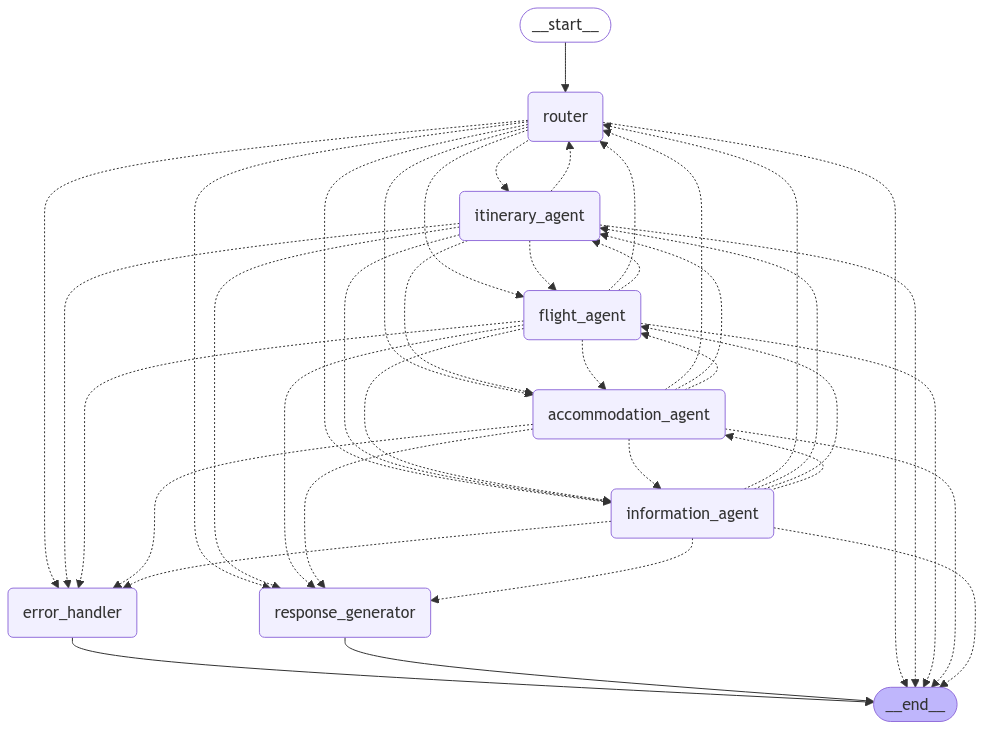

In [84]:
## Step 4: Using the Travel Assistant
# Create the travel assistant
travel_assistant = create_travel_assistant_graph()

In [89]:
# Testing the itinerary_agent

result11 = travel_assistant.invoke({"query": "Plan a 5-day trip to Tokyo in March"})
print(result11)

result12 = travel_assistant.invoke({"query": "Can you draft a 3-day trip to California in August?"})
print(result12)

result13 = travel_assistant.invoke({"query": "Please make a 5-day budget friendly itinerary for a couple with 2 kids to Austria in December."})
print(result13)

result14 = travel_assistant.invoke({"query": "Can you create a 6-day travel plan covering top 5 European castles for a solo traveller in October?"})
print(result14)

result15 = travel_assistant.invoke({"query": "Plan a 2-day trip to Miami for two couples in their thirties travelling together."})
print(result15)


{'query': 'Plan a 5-day trip to Tokyo in March', 'chat_history': [], 'agent_executor': 'itinerary_agent', 'agent_response': "Hello! Planning a 5-day trip to Tokyo in March sounds fantastic! Here’s a detailed itinerary that will help you experience the best of Tokyo, from its vibrant urban scenes to tranquil cultural spots. 🌸\n\n### **Day 1: Arrival and Exploring Shibuya**\n\n- **Morning**\n  - Arrive at Narita International Airport.\n  - Take the Narita Express (N'EX) to Tokyo Station and transfer to a local line to reach Park Hotel Tokyo.\n  - Check-in, refresh, and get ready for your adventure.\n\n- **Lunch**\n  - Enjoy delicious tempura bowls at Tendon Tenya near your hotel.\n\n- **Afternoon**\n  - Explore Shibuya: visit Shibuya 109 for trendy shopping and the iconic Hachiko Statue.\n\n- **Dinner**\n  - Try Uobei Shibuya Dogenzaka for a fun conveyor belt sushi experience.\n\n- **Evening**\n  - Experience the famous Shibuya Crossing and perhaps unwind with a drink at a local bar.\n\n

In [90]:
# Testing the flight_agent

result21 = travel_assistant.invoke({"query": "Can you help me find budget flights from Chicago to Miami around March 21, 2025?"})
print(result21)

result22 = travel_assistant.invoke({"query": "Can you share three flight options from San Francisco to New York on February 26, 2025?"})
print(result22)

result23 = travel_assistant.invoke({"query": "What are the three cheapest flight options available for 1 traveller from San Francisco to Alaska in April 2025?"})
print(result23)

result24 = travel_assistant.invoke({"query": "Are there any direct flights from Seatlle to New Delhi in the second week of May?"})
print(result24)

result25 = travel_assistant.invoke({"query": "What is the cheapest, direct flight from New York to London in December 2025?"})
print(result25)

{'query': 'Can you help me find budget flights from Chicago to Miami around March 21, 2025?', 'chat_history': [], 'agent_executor': 'flight_agent', 'agent_response': "Hello! I'd be delighted to help you find a budget-friendly flight from Chicago to Miami around your specified date, March 21, 2025. I've found an option that's quite affordable, although it's a few days after March 21. Here are the details:\n\n- **Destination**: Miami (MIA)\n- **Departure Date**: March 25, 2025\n- **Price**: $47.95 USD\n\n👍 **This flight is a great deal** if you can be flexible with your travel dates. However, if you need to stick closer to March 21, I have some tips and strategies to help you find the best possible rates:\n\n### Alternative Flight Options\n- **Check Other Dates**: Exploring dates slightly before or after March 21 could lead to significant savings. Flight prices can vary based on demand, especially near weekends or holidays.\n- **Set Flight Alerts**: Use travel apps or websites to set up 

In [91]:
# Testing the accommodation_agent

result31 = travel_assistant.invoke({"query": "Please find 3 hotel recommendations in Paris for 2 guests from May 2 to May 10, 2025 in a price range of $100 to $200 per night."})
print(result31)

result32 = travel_assistant.invoke({"query": "Can you help find hotels in New York City for the last weeks of April 2025 for a single person in a nightly budget range of $400 to $600?"})
print(result32)

# result33 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result33)

# result34 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result34)

# result35 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result35)

{'query': 'Please find 3 hotel recommendations in Paris for 2 guests from May 2 to May 10, 2025 in a price range of $100 to $200 per night.', 'chat_history': [], 'agent_executor': 'accommodation_agent', 'agent_response': 'It seems there was an issue processing your request for hotel recommendations in Paris. While I’m unable to provide specific hotel listings at the moment, I can offer some general advice for booking hotels in Paris within your budget.\n\nWhen searching for hotels in Paris within the $100 to $200 price range, consider looking into neighborhoods like the Latin Quarter, Montmartre, or Bastille for more affordable options that still offer plenty of charm and convenience. Booking well in advance and checking for special deals or discounts on hotel websites or through travel platforms like Booking.com, Expedia, or Airbnb can also help you secure a better rate.\n\nTo help me assist you better, could you please specify any additional preferences you might have? For example, a

In [87]:
# Testing the information_agent
result41 = travel_assistant.invoke({"query": "What's the weather like in Rome in July?"})
print(result41)

result42 = travel_assistant.invoke({"query": "What's your travel advice for Amsterdam and London in July?"})
print(result42)

result43 = travel_assistant.invoke({"query": "Is there any specific travel advisory for Bali in Indonesia in October 2025?"})
print(result43)

result44 = travel_assistant.invoke({"query": "What safety advice do you have for foreigners need to be safe in tourst attractions in Paris?"})
print(result44)

result45 = travel_assistant.invoke({"query": "Is India safe for travel for foreign tourists particularly solo women travellers?"})
print(result45)

{'query': "What's the weather like in Rome in July?", 'chat_history': [], 'agent_executor': 'information_agent', 'agent_response': '**Exploring Rome in July: Weather Overview 🌞**\n\n**Temperature Details:**\n- **Daytime:** Expect average temperatures ranging between **25°C (77°F) and 30°C (86°F)**.\n- **Evenings:** Cooler than daytime but still warm, perfect for pleasant night walks around the city.\n- **Note:** Temperatures exceeding 30°C are not unusual.\n\n**Sunshine and Rainfall:**\n- July is one of the driest months in Rome, so rain is rarely a concern.\n- The city enjoys plenty of sunshine, making it ideal for sightseeing and enjoying the vibrant street life.\n\n**Tips for a Comfortable Visit:**\n- **Stay Hydrated:** Always carry water with you to beat the heat.\n- **Sun Protection:** Use sunscreen, wear a hat, and consider carrying an umbrella for shade to protect against the strong sun.\n- **Plan Your Day:** Try to schedule physically demanding activities during cooler times—ea

In [88]:
# Testing the erroneous situations
result51 = travel_assistant.invoke({"query": "Book me a trip to Mars next Tuesday."})
print(result51)

result52 = travel_assistant.invoke({"query": "What's your travel advice for the Sun?"})
print(result52)

result53 = travel_assistant.invoke({"query": "I am losing my mind. How is your mind?"})
print(result53)

result54 = travel_assistant.invoke({"query": "Please make Arvind Ranganathan marry me."})
print(result54)

{'query': 'Book me a trip to Mars next Tuesday.', 'chat_history': [], 'agent_executor': 'flight_agent', 'agent_response': "Hello! 🚀 Your interest in a trip to Mars is truly out of this world! Unfortunately, **commercial travel to Mars isn't available just yet**. As of now, my resources and expertise are focused solely on Earth-bound destinations.\n\n### Stay Updated on Space Travel\nFor future reference, you might want to keep an eye on these organizations, as they're making strides in space tourism and may eventually make Mars a reachable destination:\n- **SpaceX**\n- **NASA**\n- **Blue Origin**\n\n### Exploring Earth Instead?\nIn the meantime, if you're itching for an adventure closer to home, I'd love to help you plan a trip right here on Earth. Whether it's the sandy beaches of the Maldives or the historic streets of Rome, I can assist with:\n- Flight bookings\n- Travel tips\n- Destination recommendations\n\nJust share your intended destination, travel dates, and any other preferen

In [93]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

In [94]:
from ragas.testset.graph import Node, NodeType

# Get the total number of vectors in the index
num_vectors = travel_db.ntotal

# Iterate using index reconstruction
for i in range(num_vectors):
    # Reconstruct the vector/document at index i
    doc = travel_db.reconstruct(i)
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

AttributeError: 'FAISS' object has no attribute 'ntotal'

In [95]:
# QUALITY CHECK OUTPUT: Print contents of travel_db (a langchain_community.vectorstores.faiss.faiss object)
# Print each row in the vector store object
for index, doc_id in travel_db.index_to_docstore_id.items():
    doc = travel_db.docstore.search(doc_id) # Get the document from docstore using doc_id

    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )

In [96]:
kg

KnowledgeGraph(nodes: 2553, relationships: 0)

In [97]:
import ragas

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset.transforms import default_transforms, apply_transforms

In [98]:
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [99]:
print(ragas.__version__)
transformer_llm = generator_llm
embedding_model = generator_embeddings

0.2.13


In [107]:
# Print initial document count
doc_ids = list(travel_db.index_to_docstore_id.values())
docs = [travel_db.docstore.search(doc_id) for doc_id in doc_ids]
print(f"Initial document count: {len(docs)}")

# Print count after filtering
filtered_docs = [doc for doc in docs if len(doc.page_content.split()) > 90]
print(f"Filtered document count: {len(filtered_docs)}")

# Only proceed if we have documents
if len(filtered_docs) > 0:
    default_transforms = default_transforms(
        documents=filtered_docs, 
        llm=transformer_llm, 
        embedding_model=embedding_model
    )
else:
    raise ValueError("No documents meet the minimum length requirement of 90 words")


Initial document count: 2553
Filtered document count: 2


In [109]:
kg.save("temp.json")
ai_across_years_kg = KnowledgeGraph.load("temp.json")
ai_across_years_kg

KnowledgeGraph(nodes: 2553, relationships: 0)

In [103]:
# Get documents from FAISS docstore
docs = travel_db.docstore._dict.values()

# Print length of each document
for doc in docs:
    print(f"Document content length: {len(doc.page_content)} characters")
    # Or count tokens/words
    print(f"Word count: {len(doc.page_content.split())}")

Document content length: 784 characters
Word count: 95
Document content length: 769 characters
Word count: 94
Document content length: 120 characters
Word count: 11
Document content length: 120 characters
Word count: 11
Document content length: 120 characters
Word count: 11
Document content length: 120 characters
Word count: 11
Document content length: 120 characters
Word count: 11
Document content length: 120 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document content length: 121 characters
Word count: 11
Document c

In [ ]:
# QUALITY CHECK OUTPUT: Print contents of travel_db (a langchain_community.vectorstores.faiss.faiss object)
# Print each row in the vector store object
for index, doc_id in travel_db.index_to_docstore_id.items():
    doc = travel_db.docstore.search(doc_id) # Get the document from docstore using doc_id
    print(f"Index: {index}")
    print(f"Document ID: {doc_id}")
    print(f"Document ID: {doc.}")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}\n")